<a href="https://colab.research.google.com/github/ctugulan/FunFluidProblems/blob/main/Sea_Ice_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sea Ice Image Segmentation with Segment Anything Model (SAM)

The Segment Anything Model (SAM) was released by META AI in 2023 to foster research into foundation models for image segmentation. The model is promptable and pretrained on a broad dataset, so it can transfer zero-shot to new image distributions and tasks.
Here, we demonstrate how SAM works by working with a single sea ice image from SCALE (Southern oCean seAsonaL Experiment) in 2022.


Mounted at /content/drive


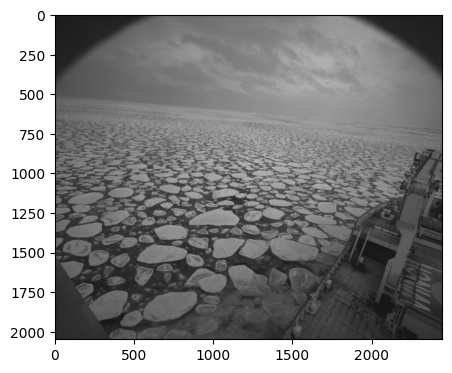

In [ ]:
# Display Cropped and Perspective Corrected image
import matplotlib.pyplot as plt
import cv2
import os

# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

DIR_PATH = '/content/drive/MyDrive/Colab Notebooks/SeaIceImageSegmentation/sea_ice_sample_image'
IMAGE_NAME = '17-07-04 10-00-53.bmp'
IMAGE_PATH = os.path.join(DIR_PATH, IMAGE_NAME)

image = cv2.imread(IMAGE_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('on')
plt.show()

## 1. Data Processing


Before we can work with this data, some preprocessing is necessary to obtain the perspective corrected images. This process involves *camera calibration* and *camera orientation*.

### Camera Calibration (Theory)
*Geometric camera calibration* is a process used to estimate camera parameters required for correcting geometric distortion and measuring object size in real-world units in computer vision applications. It involves obtaining 3D world points and their corresponding 2D image points, typically using multiple images of a calibration pattern like a checkerboard.

The camera matrix that maps the 3D real-world scene onto the image plane is calculated by the calibration algorithm using the extrinsic and intrinsic parameters. Extrinsic parameters describe the camera's location in the real-world, while intrinsic parameters represent the optical center and focal length of the camera.


The **extrinsic parameters** consist of a rotation, $\mathbf{R}$, and a translation, $\mathbf{t}$, where the origin of the camera’s 3D coordinate system is at its optical center and the $z$-axis points out of the camera. In this system, the $x$- and $y$-axis define the image plane.
Space (world) coordinates are a separate 3D coordinate system that represents the real-world scene.


calibration-rt-coordinates-outline.svg

Intrinsic parameters include the focal length (`fx`, `fy`) and optical center (`cx`, `cy`). They are part of the camera intrinsic matrix, $K$, defined by

\begin{align*}
K=
\begin{bmatrix}
f_x & s & c_{x} \\
0 & f_{y} & c_{y} \\
0 & 0 & 1
\end{bmatrix}.
\end{align*}

In this code, the intrinsic camera parameters were calculated by Giulio Passerotti (PhD student  in Ocean Engineering at the University of Melbourne, Australia) using [Matlab's Camera Calibrator App](https://www.mathworks.com/help/vision/ug/camera-calibration.html). For details, see Zhang, Z. “A Flexible New Technique for Camera Calibration.” IEEE Transactions on Pattern Analysis and Machine Intelligence. 22, no. 11 (November 2000): 1330–34. https://doi.org/10.1109/34.888718.

Extrinsic parameters consist of elevation (`elev`), tilt (`tilt`), and roll (`roll`). They define the camera's orientation in the 3D space. The `cameratransform` package is used to create a `RectilinearProjection` object using the intrinsic parameters and a `SpatialOrientation` object using the extrinsic parameters. These objects are then combined to create a Camera object.


### Orthorectification

The `cameratransform` package provides functionality to convert between camera coordinates and space (world) coordinates, by considering the camera's projection and spatial orientation.

The `cameratransform` package is used to create a `SpatialOrientation` object that defines the camera's orientation (`tilt`, `roll`) and position (`elevation`) in the 3D space. This object, along with the `RectilinearProjection` object containing intrinsic parameters, is used to create a Camera object, which represents the complete camera model.

The Camera object `cam` provides methods to transform points between camera and space coordinates. One such operation is orthorectification, which is the process of removing perspective distortion from an image to obtain a top-down view (orthographic projection) of the scene. In the provided code, the `getTopViewOfImage` method is used to perform orthorectification on the input image, transforming it into a top-down view using the defined camera model. This method considers both the intrinsic and extrinsic parameters of the camera, ensuring accurate transformation between the coordinate systems.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 1.2 MB/s eta 0:00:00


True

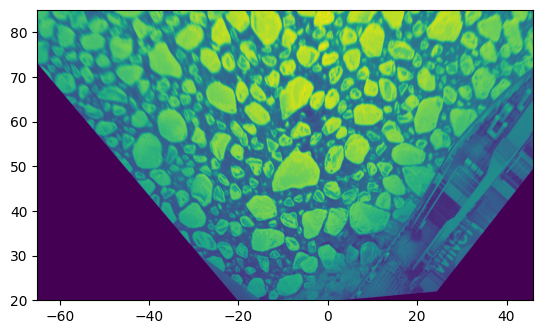

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
!pip install -q cameratransform
import cameratransform as ct


# Intrinsic camera parameters
fx = 1453.86    # in px
fy = 1448.71    # in px
cx = 1234.44    # in px
cy = 1011.30    # in px
sc = 0.05 # in m [1 px=0.05m]

# Extrinsics
elev = 24 # in m [24]
tilt = 75 # in deg [75]
roll = 5  # in deg [5]

# Read the image
im = plt.imread(IMAGE_PATH)

# Create RectilinearProjection object
projection = ct.RectilinearProjection(focallength_x_px=fx,
                                      focallength_y_px=fy,
                                      center_x_px=cx,
                                      center_y_px=cy,
                                      image=im)

# Create SpatialOrientation object
orientation = ct.SpatialOrientation(elevation_m=elev,
                                    tilt_deg=tilt,
                                    roll_deg=roll)

# Create Camera object
cam = ct.Camera(projection, orientation)

# Perform orthorectification
top_im = cam.getTopViewOfImage(image=im, # image as numpy array
                               extent=[-65, 46, 20, 85],# extent of the resulting top view in meters: [x_min, x_max, y_min, y_max]
                               scaling=0.05, #the scaling factor, how many meters is the side length of each pixel in the top view
                               do_plot=True# whether to directly plot the resulting image in a matplotlib figure
                               )


# # save corrected image
filename = f"tilt{cam.tilt_deg:.0f}roll{cam.roll_deg:.0f}elevation{cam.elevation_m:.0f}.png"
output_file = os.path.join(DIR_PATH, IMAGE_NAME.replace(".bmp", " ") + filename)
cv2.imwrite(output_file, top_im)


## Automatically generating object masks with Segment Anything Model (SAM)
The class `SamAutomaticMaskGenerator` is capable of generating masks for the entire image by sampling a large number of single point input prompts over the image, from each of which SAM can predict multiple masks. Then masks are filtered for quality and deduplicated using non-maximal supression. Further improvement of mask quality and quantity can be made by running prediction on multiple crops of the image or post processing masks to remove small disconnected regions or holes.


### Display Sample Data
We'll use our sample orthorectified image from the data processing step.

Mounted at /content/drive


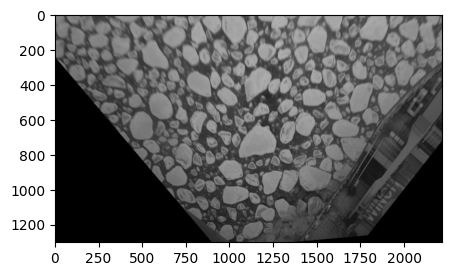

In [ ]:
# Display Cropped and Perspective Corrected image
import matplotlib.pyplot as plt
import cv2
import os

# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

DIR_PATH = '/content/drive/MyDrive/Colab Notebooks/SeaIceImageSegmentation/sea_ice_sample_image'
# IMAGE_NAME = '22-07-19 13-46-32 croppedImage.png'
IMAGE_NAME = '17-07-04 10-00-53 tilt75roll5elevation24.png'
IMAGE_PATH = os.path.join(DIR_PATH, IMAGE_NAME)

image = cv2.imread(IMAGE_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('on')
plt.show()

# Set up

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import cv2

def show_anns(anns, max_area = 35000):
    if len(anns) == 0: # check for empty annotations
        return

    # Sort annotations by area and find the maximum area
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)

    # Get the current axis and turn off auto-scaling
    ax = plt.gca()
    ax.set_autoscale_on(False)

    # Create an empty image array with the same shape as the first (largest) mask, including additional dimension for color (RGBA)
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0 # alpha channel set to zero, making entire image fully transparent

    # Colormap instance
    # Colormap and normalization instance
    colormap = cm.viridis

    # # Applying color to the masks
    # for ann in sorted_anns:
    #     m = ann['segmentation']
    #     color_mask = np.concatenate([np.random.random(3), [0.35]])
    #     img[m] = color_mask

    for ann in sorted_anns:
        m = ann['segmentation']
        relative_size = ann['area'] / max_area
        color = colormap(relative_size)[:3]  # Get RGB values
        color_mask = np.concatenate([color, [0.35]])  # Add alpha value
        img[m] = color_mask

    # Display the image
    ax.imshow(img)

## Environment set-up
Ensure acess to GPU, install the required project dependencies and download the SAM weights.

In [ ]:
 # Make sure you have access to the GPU
!nvidia-smi

 # Create a HOME constant to make it easier for us to manage datasets, images and models
import os
HOME = os.getcwd()
print("HOME:", HOME)

%cd {HOME}

using_colab = True

if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    # !pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision # maybe remove later
    !mkdir {HOME}/weights
    %cd {HOME}/weights

    !wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

Tue Jan 30 18:23:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Automatic mask generation
To run automatic mask generation, provide a SAM model to the SamAutomaticMaskGenerator class. Set the path below to the SAM checkpoint. Running on CUDA with the default model is recommended.

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

mask_generator = SamAutomaticMaskGenerator(sam)

/content/weights/weights/sam_vit_h_4b8939.pth ; exist: True


To generate masks, run `generate` on an image.

In [ ]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:

* `segmentation`: the mask with (W, H) shape, and bool type, where W and H are the width and height of the original image, respectively [`np.ndarray`]
* `area`: the area of the mask in pixels [`int`]
* `bbox`: the boundary box detection in xywh format [`List[int]`]
* `predicted_iou`: the model's own prediction for the quality of the mask [`float`]
* `point_coords`: the sampled input point that generated this mask [`List[List[float]]`]
* `stability_score`: an additional measure of mask quality [`float`]
* `crop_box`: the crop of the image used to generate this mask in xywh format [`List[int]`]

In [ ]:
print(len(masks))
print(masks[0].keys())

327
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Show all the masks overlayed on the image.

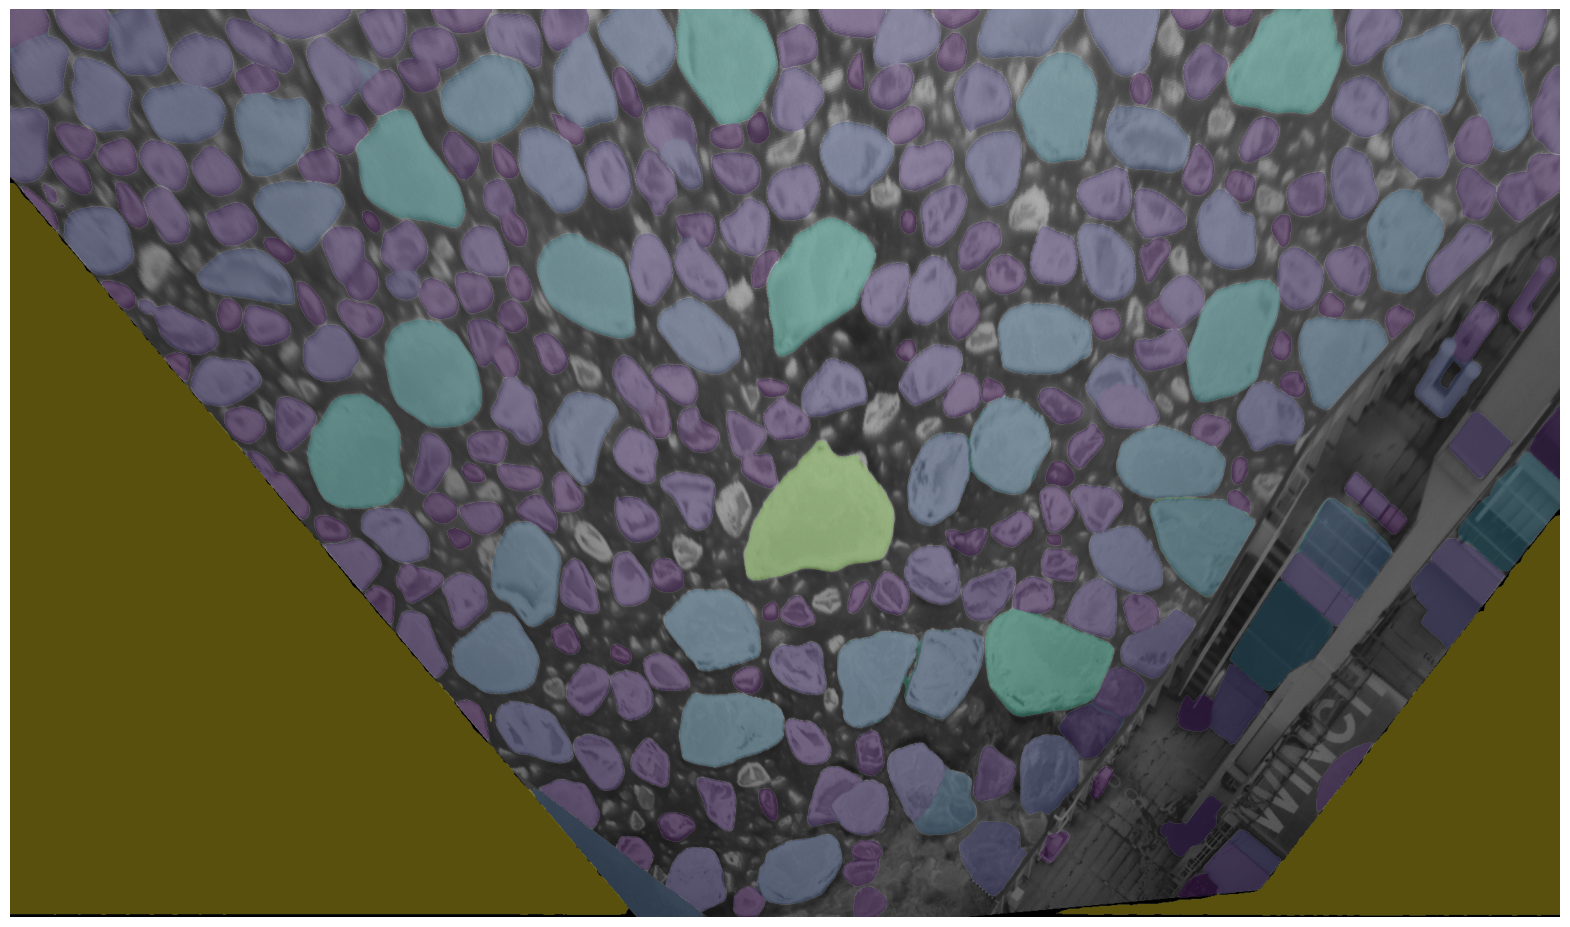

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

# Automatic mask generation options
There are several tunable parameters in the automatic mask generation (`SamAutomaticMaskGenerator`) that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Generation can be automatically run on multiple crops of the image to get improved performance for smaller objects and post-processing can remove stray pixels and holes. See example configuration that samples more masks below:

- `model`: The model used for mask generation.
- `points_per_side`: The number of points per side used to sample the image.
- `pred_iou_thresh`: The threshold used to remove low-quality masks based on the predicted intersection over union (IOU) score.
- `stability_score_thresh`: The threshold used to remove duplicate masks based on their stability score.
- `crop_n_layers`: The number of layers used for cropping the image to improve performance on smaller objects.
- `crop_n_points_downscale_factor`: The factor used for downscaling the cropped image.
- `min_mask_region_area`: The minimum area required for a region to be considered a valid mask. Note that post-processing using open-cv is required to use this parameter.

In [ ]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.5,
    stability_score_thresh=0.95,
    box_nms_thresh = 0.5,
    crop_n_layers = 2,
    crop_nms_thresh = 0.5,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

masks2 = mask_generator_2.generate(image)
print(f"Number of masks: {len(masks2)}")

Number of masks: 450


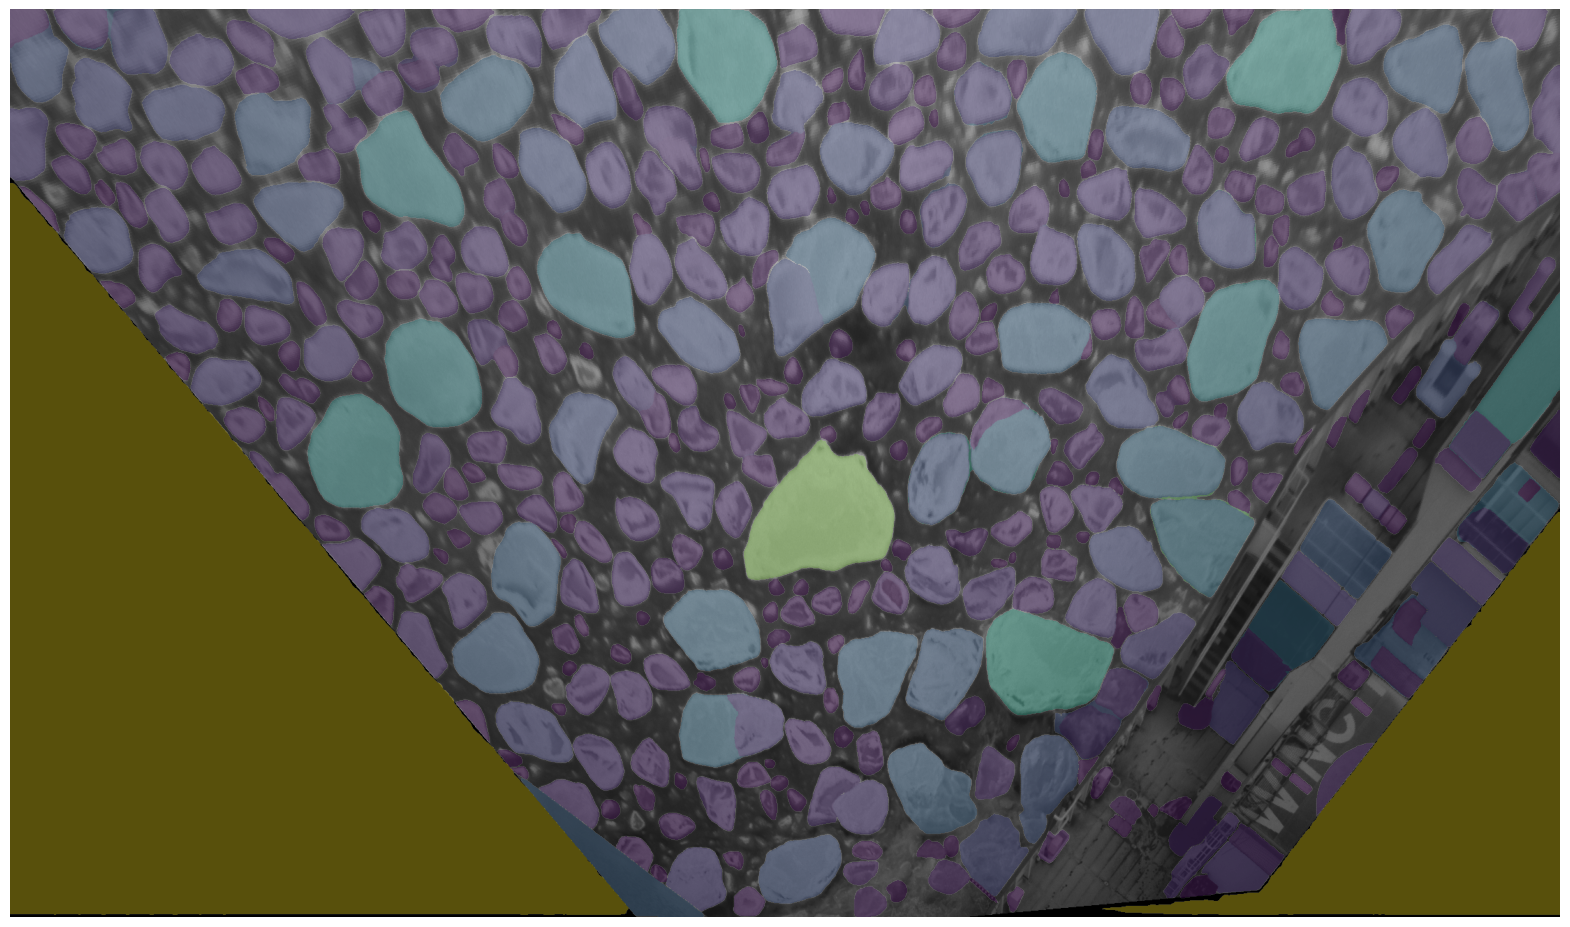

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()

## Interaction with segmentation results

We can interact with the masks once they are generated. In this example they are ordered by area from smallest to largest.

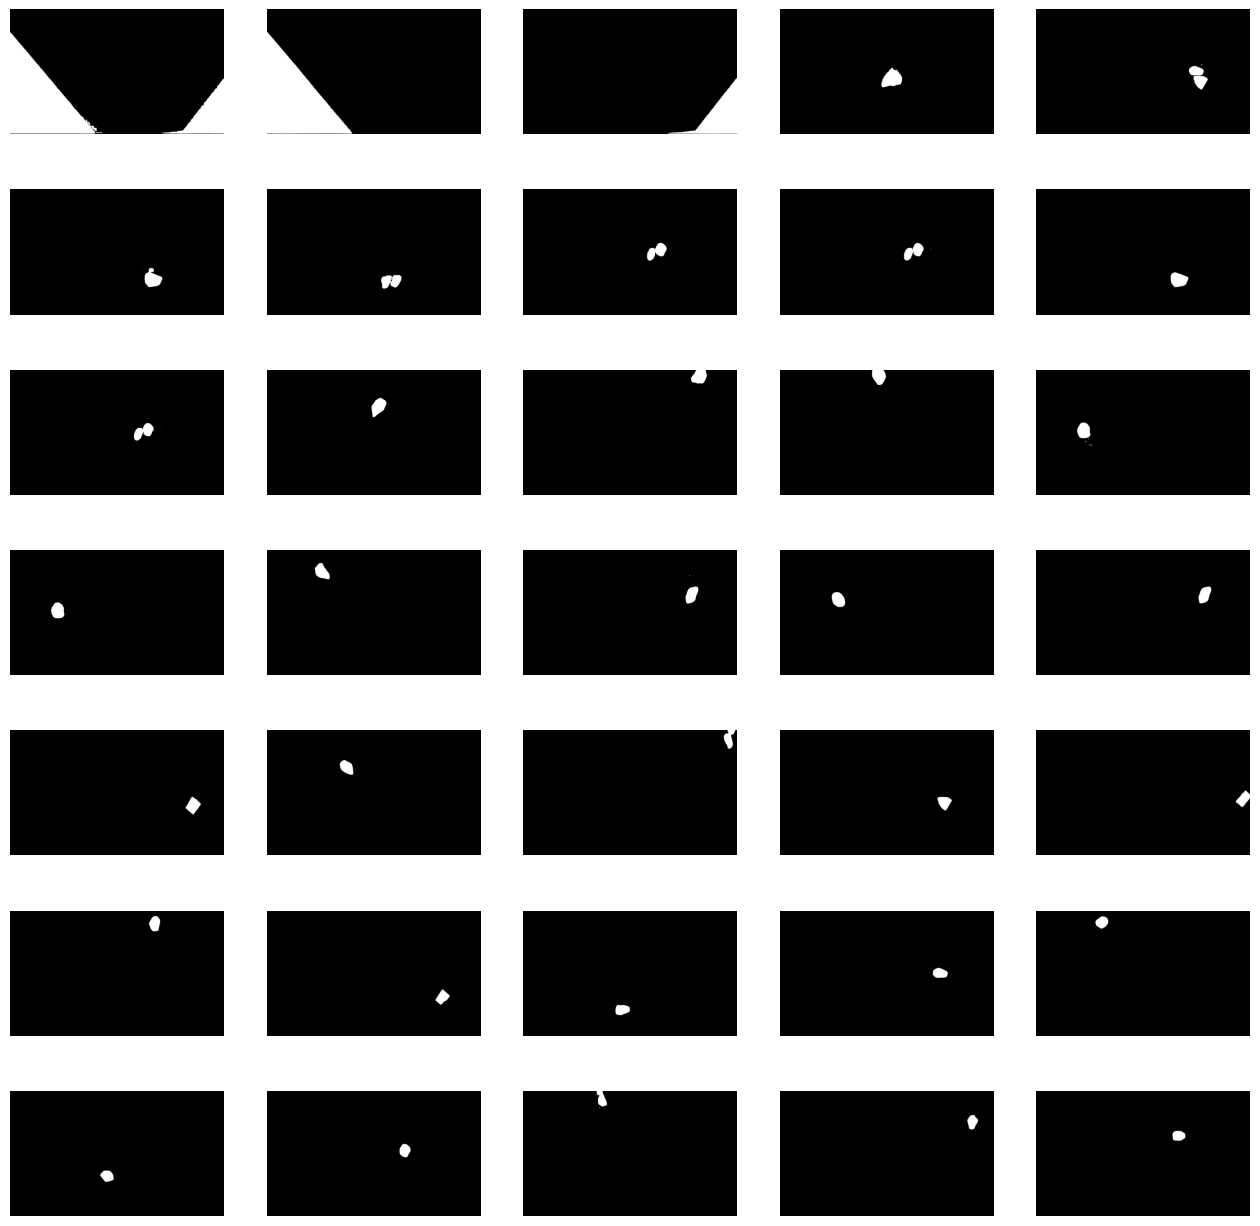

In [ ]:

masks = [
    mask['segmentation']
    for mask in sorted(result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images = masks[:35],
    grid_size = (7,5),
    size = (16,16)
)

Visualize the size distributions of the areas of each mask by extracting the area values from the segmentation results.

In [ ]:
# Get area values from list of segmentation results
area_values = [mask['area'] for mask in masks2]

# Define a threshold for the maximum allowed mask area
area_threshold = 100000

# Filter out areas larger than the threshold
filtered_areas = [area for area in area_values if area <= area_threshold]

[5635, 2730, 1969, 3085, 555, 442, 3743, 396, 205, 1134, 3610, 12682, 3198, 5573, 8765, 10421, 6589, 2734, 3235, 11957, 3108, 1551, 3040, 481, 838, 5142, 759, 283, 647, 170, 579, 11051, 11248, 3100, 20363, 4676, 4710, 10147, 1511, 1950, 8888, 951, 1675, 3161, 2347, 7120, 1096, 3507, 8515, 1113, 581, 858, 417, 641, 277, 935, 1244, 1540, 11357, 7006, 7110, 5175, 3480, 4452, 5893, 4601, 8749, 5218, 7458, 3516, 10338, 1473, 3865, 1712, 3477, 2998, 2724, 1473, 2981, 10294, 466, 2500, 4576, 396, 398, 5696, 849, 785, 2654, 186, 7303, 12398, 16269, 11088, 6623, 1830, 3179, 1294, 786, 4570, 3078, 17416, 4354, 7469, 850, 8602, 858, 313, 668, 1055, 1487, 337, 1025, 653, 12685, 2100, 13577, 6494, 9950, 2586, 607, 345, 274, 3932, 16241, 7743, 7088, 8679, 3427, 5123, 2463, 3405, 3314, 7371, 961, 9875, 2206, 1386, 7095, 3463, 3217, 4435, 1620, 3272, 1114, 5211, 1897, 721, 2839, 2232, 1896, 17657, 16446, 5264, 4821, 3188, 3207, 2546, 3962, 1496, 2299, 2946, 703, 1060, 5367, 3406, 2456, 1765, 14696, 18

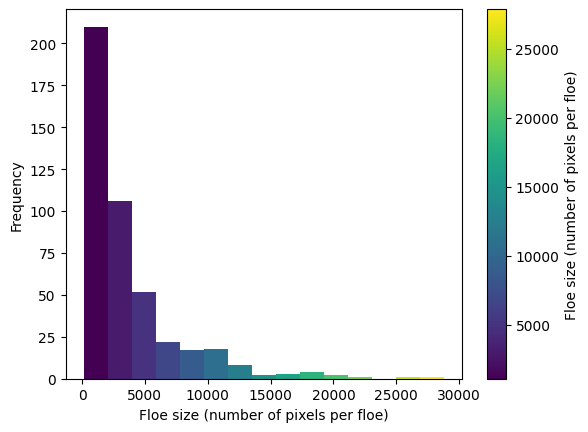

In [ ]:
import matplotlib.pyplot as plt

# Assuming filtered_areas is already defined and contains the area sizes
sizes = filtered_areas
print(sizes)

# Generate histogram data
n_bins = 15  # number of bins
fig, ax = plt.subplots()
n, bins, patches = ax.hist(sizes, n_bins, color='blue')

# Instead of using frequency, we use the bin edges to determine the color
# The color will be based on the average size in each bin
bin_centers = 0.5 * (bins[:-1] + bins[1:])
norm = plt.Normalize(bin_centers.min(), bin_centers.max())

for bin_center, thispatch in zip(bin_centers, patches):
    color = plt.cm.viridis(norm(bin_center))
    thispatch.set_facecolor(color)

# Add a color bar
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.viridis), ax=ax, label='Floe size (number of pixels per floe)')

# Set labels and title
ax.set_xlabel('Floe size (number of pixels per floe)')
ax.set_ylabel('Frequency')

# Show the plot
plt.show()


# Generate Segmentation with Prompts
`SamPredictor` provides an interface for prompting the model.  The necessary embeddings are first calculated using the `set_image` method. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take both point and box prompts as input, as well as masks from the previous iteration of the prediction. Here we look at point and box prompts.

### $K$-Means Clustering
This code performs $k$-means clustering on the orthorectified image to improve the distinction between objects (sea ice floes), which will later facilitate the application of the distance transform needed to identify the initial seeds.



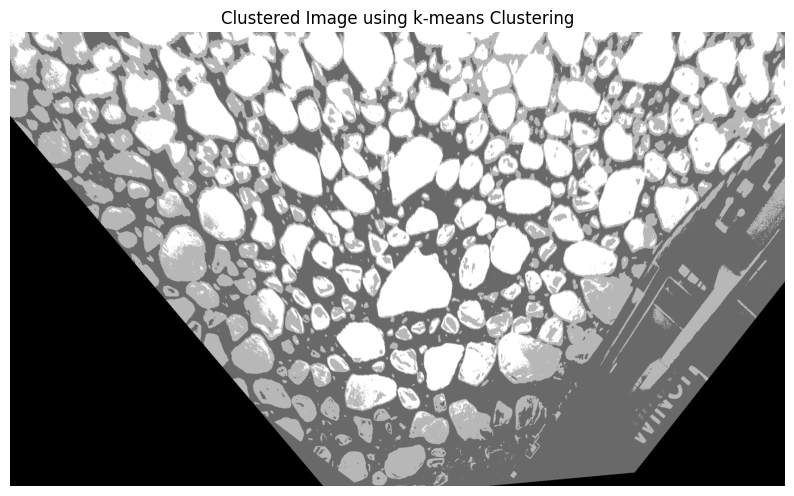

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt
from skimage.morphology import dilation, disk
from skimage.feature import peak_local_max
from skimage.measure import regionprops_table

def k_means_clustering(image_path, k):
    # Load image and convert to grayscale
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Create a mask for non-black pixels (assuming black background)
    mask = gray > 0

    # Apply the mask to the grayscale image to keep only non-black pixels
    gray_masked = gray * mask

    # Reshape the masked image to a 2D array of non-black pixels
    non_black_pixels = gray_masked[mask]
    non_black_pixels = np.float32(non_black_pixels).reshape((-1, 1))

    # Perform k-means clustering
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(non_black_pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Convert back to 8-bit values
    centers = np.uint8(centers)

    # Map the cluster labels to the cluster centers
    segmented_data = centers[labels.flatten()]

    # Create an empty array with the same shape as the grayscale image to store the segmented image
    segmented_image = np.zeros_like(gray)

    # Place the segmented data (mapped cluster centers) in the segmented image using the previously created binary mask
    np.place(segmented_image, mask, segmented_data)
    return segmented_image

# Load the original image
top_im_path = os.path.join(DIR_PATH, "17-07-04 10-00-53 tilt75roll5elevation24.png")


# Perform k-means clustering with k=3
clustered_image = k_means_clustering(top_im_path, k=3)

# Visualization
plt.figure(figsize=(10, 10))
plt.imshow(clustered_image, cmap='gray')
plt.axis('off')
plt.title("Clustered Image using k-means Clustering")
plt.show()

The purpose of performing $k$-means clustering in this case is to enhance the contrast between the sea ice floes and the background, as well as between the different floes themselves. By using $k$-means clustering, the algorithm assigns each pixel to one of the $k$ clusters, resulting in a segmented image with a reduced number of intensity levels. This process simplifies the image and makes it easier to apply the distance transform to identify the initial seeds. These seeds will be placed at the local maxima (center of the object, ideally) based on the distance transform using "City Block" distance metrics. This step is useful for further processing, _e.g._ object identification and measurement.

### Distance Transform

This code is processing the image to identify the initial seeds for further segmentation. The distance transform is computed on the binary image, and the local maxima are found to represent the center of the objects (sea ice floes). The local maxima are then dilated, and the centroids of the connected components are used as input points. These input points can be used later for object identification and measurement.


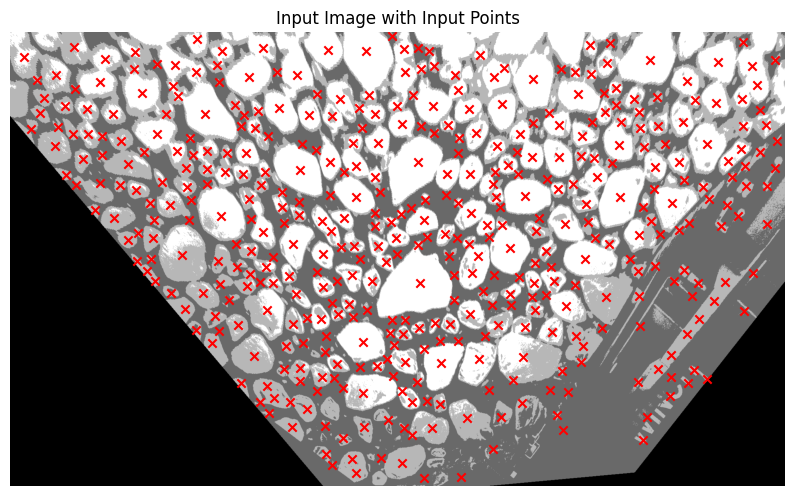

In [ ]:
# Since the clustered_image is already in grayscale, we can skip the conversion step
gray = clustered_image

# Apply Otsu's binarization method to threshold the grayscale image
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Compute the distance transform on the binary image
dist_transform = distance_transform_edt(binary)

# Find local maxima
local_max = peak_local_max(dist_transform, min_distance=10, threshold_abs=0)

# Create an empty binary image with the same size as the input image
local_max_image = np.zeros_like(gray, dtype=bool)

# Mark the local maxima in the binary image
local_max_image[local_max[:, 0], local_max[:, 1]] = True

# Dilate local maxima
T = 15
dilated = dilation(local_max_image, disk(T))

# Find connected components and get their centroids as input points
_, labels = cv2.connectedComponents(dilated.astype(np.uint8))
input_points = np.column_stack((regionprops_table(labels, properties=['centroid'])['centroid-0'], regionprops_table(labels, properties=['centroid'])['centroid-1']))
input_labels = np.ones(len(input_points), dtype=int)

plt.figure(figsize=(10, 10))
plt.imshow(gray, cmap='gray')
plt.scatter(input_points[:, 1], input_points[:, 0], c='r', marker='x')
plt.axis('off')
plt.title("Input Image with Input Points")
plt.show()

### Generate Segmentation with Point Prompt

In [ ]:
mask_predictor = SamPredictor(sam)

In [ ]:
# Helper functions to plot masks, point and boxes on the image.
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

Visualize the point on the image (user prompt) which will help to identify our target object.

In [ ]:
x_new, y_new = 1150, 750
input_point = np.array([[x_new, y_new]])
input_label = np.array([1])
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

Make a prediction to generate a mask of the object. Note: When `multimask_output=True`, the algorithm returns three masks.

In [ ]:
import cv2
import numpy as np
import supervision as sv

mask_predictor.set_image(image)

masks, scores, logits = mask_predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
print(masks.shape)  # (number_of_masks) x H x W

In [ ]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

### Generate Segmentation with Bounding Box

Bounding box prompts can also be provided via the `predict` method.

**Draw Box**

In [ ]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

Execute cell below and use your mouse to draw bounding box on the image

In [ ]:
if using_colab:
  from google.colab import output
  output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

In [ ]:
widget.bboxes

### Generate masks with SAM

In [ ]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 1371, 'y': 302, 'width': 813, 'height': 981, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [ ]:
import cv2
import numpy as np
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

## Results visualisation with Supervision


In [ ]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red())

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [ ]:
import supervision as v

sv.plot_images_grid(
    images=masks,
    grid_size=(1, 3),
    size=(16, 4)
)

## Next Step: Fine-tuning
Later, we can fine-tune the model to obtain higher performance on our use case, without having to deal with the computational cost of training a model from scratch. In order to fine tune SAM, we need to extract the underlying pieces of its architecture. The image encoder has a complex architecture with many parameters, so it makes sense to focus on the mask decoder which is more lightweight, and hence more efficient to tune. [How To Fine-Tune Segment Anything](https://encord.com/blog/learn-how-to-fine-tune-the-segment-anything-model-sam/) by A. Bonnet describes how to fine-tune SAM using the following three things:
- Images on which to draw segmentations ✔
- Segmentation ground truth masks ✔
- Prompts to feed into the model (_e.g._ can use initialization points from preprocessing distance transform step)

